# Admissions distributions by cluster & ICU

## Aims and objectives

Outputs of this notebook are inputs to the simple ABM.

- Patient intime distributions per cluster and ICU; these provide parameters from which we perform multinomial draws to admit patients to hospital as part of the ABM, one of the core stochastic elements of the model.
- Investigations into sparsity of intime data

Comments
- Trade off between model accuracy (additional features used in best estimator models) versus creating too sparse distributions to estimate intime frequency. That is why we create patient clusters instead of using age and diagnosis as in older notebook.

## Install packages

In [1]:
from collections import Counter
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Load files

In [5]:
# set directory
# Set directory
os.chdir("/Users/.../raw_data")
df =  pd.read_csv('icustays.csv') # Best model outputs without ICU

df.shape

# Set directory
os.chdir("/Users/.../processed_data")

# Check desired file exists
os.listdir()

df =  pd.read_csv('clustered_data_for_priors.csv') # Best model outputs without ICU


In [6]:
df.head()

,Unnamed: 0,index,gender,ethnicity_grouped,admission_type,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,...,FIRST_CAREUNIT,INTIME,OUTTIME_COLLAPSED,age_group,dod_exists,sepsis,diagnoses_count,ideal_ICU,INTIME_COLLAPSED_day,cluster_number
0,24,37297,F,white,NEWBORN,1.0,True,0.0,1.0,True,...,NICU,2133-06-28 02:15:57,2003-03-02 10:02:47 UTC,0.0-19.0,False,False,5.0,NICU,2003-03-02,1
1,28,7407,F,white,ELECTIVE,1.0,True,0.0,1.0,True,...,SICU,2133-06-29 21:58:16,2003-03-03 22:08:55 UTC,40.0-59.0,True,False,3.0,SICU,2003-03-03,1
2,48,18671,M,white,NEWBORN,1.0,True,0.0,1.0,True,...,NICU,2133-07-14 10:55:45,2003-03-04 14:53:03 UTC,0.0-19.0,False,False,6.0,NICU,2003-03-04,1
3,50,59989,F,black,NEWBORN,1.0,True,0.0,1.0,True,...,NICU,2133-06-23 11:09:36,2003-03-04 13:29:16 UTC,0.0-19.0,False,False,4.0,NICU,2003-03-04,1
4,59,7824,F,white,NEWBORN,1.0,True,0.0,1.0,True,...,NICU,2133-05-12 01:48:15,2003-03-04 07:53:08 UTC,0.0-19.0,False,False,3.0,NICU,2003-03-04,1


In [2]:

df =  pd.read_csv('files/.../clustered_data_for_priors.csv') # Best model outputs without ICU

df.head()

,index,gender,ethnicity_grouped,admission_type,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,first_category,...,FIRST_CAREUNIT,INTIME,OUTTIME_COLLAPSED,age_group,dod_exists,sepsis,diagnoses_count,ideal_ICU,INTIME_COLLAPSED_day,cluster_number
0,37297,F,white,NEWBORN,1.0,True,0.0,1.0,True,perinatal,...,NICU,2133-06-28 02:15:57,2003-03-02 10:02:47 UTC,0.0-19.0,False,False,5.0,NICU,2003-03-02,1
1,7407,F,white,ELECTIVE,1.0,True,0.0,1.0,True,neoplasms,...,SICU,2133-06-29 21:58:16,2003-03-03 22:08:55 UTC,40.0-59.0,True,False,3.0,SICU,2003-03-03,1
2,18671,M,white,NEWBORN,1.0,True,0.0,1.0,True,perinatal,...,NICU,2133-07-14 10:55:45,2003-03-04 14:53:03 UTC,0.0-19.0,False,False,6.0,NICU,2003-03-04,1
3,59989,F,black,NEWBORN,1.0,True,0.0,1.0,True,perinatal,...,NICU,2133-06-23 11:09:36,2003-03-04 13:29:16 UTC,0.0-19.0,False,False,4.0,NICU,2003-03-04,1
4,7824,F,white,NEWBORN,1.0,True,0.0,1.0,True,perinatal,...,NICU,2133-05-12 01:48:15,2003-03-04 07:53:08 UTC,0.0-19.0,False,False,3.0,NICU,2003-03-04,1


## Data checks

In [7]:
print(max(df.INTIME_COLLAPSED_day) )
print(min(df.INTIME_COLLAPSED_day))

2012-12-29
2003-03-01
The difference is 3591 days


## Define functions

In [8]:
# Subset a dataframe based on columns from 2 lists
def subset_df(list_1, list_2, df):
    
    subset = []
    for i in range(0, max(len(list_1), len(list_2))):
        try:
            subset.append(list_1[i])
        except: pass
        try:
            subset.append(list_2[i])
        except: pass

    return(df.loc[:, subset])

## Prepare data

In [5]:
#set directory
# Prepare data
#os.chdir("/Users/.../processed_data/priors")


In [9]:

# Subset dataframe to only required columns
essentials = [ 'INTIME_COLLAPSED_day', 'FIRST_CAREUNIT']    # Those needed to caluclate intime dists    
predictors = ['cluster_number', 'age_group', 'first_category'] # Those for which we use to predict LOS

df1 = subset_df(essentials, predictors, df)

# Create unique lists of predictors
unique_predictors = [df1.groupby(pred).count().index for pred in predictors]
unique_predictors.append(df1.groupby('FIRST_CAREUNIT').count().index)

print('Unique predictors', unique_predictors)

# # Save lists to file
import pickle
with open('unique_predictors.pkl', 'wb') as f:
       pickle.dump(unique_predictors, f)


Unique predictors [Int64Index([1, 2, 3, 4], dtype='int64', name='cluster_number'), Index(['0.0-19.0', '20.0-39.0', '40.0-59.0', '60.0-79.0', '80-100'], dtype='object', name='age_group'), Index(['circulatory', 'digestive', 'infectious|parasitic', 'injury|poisoning',
       'mental', 'metabolic|immunity', 'musculoskeletal', 'neoplasms',
       'nervous', 'other', 'perinatal', 'respiratory'],
      dtype='object', name='first_category'), Index(['CCU', 'CSRU', 'MICU', 'NICU', 'SICU', 'TSICU'], dtype='object', name='FIRST_CAREUNIT')]


# Run code for ICUs

In [10]:
unique_predictors[3] #ICU list

unique_predictors[3][3] #to get NICU

'NICU'

In [11]:
0.8*4147 #3317 days

3317.6000000000004

In [24]:
df1.loc[:, 'idx'] = range(0, df1.shape[0]) # Create new index column

# Initialise results lists
dprob_list_new = []
bins = np.zeros([6,4])

for i, icu in enumerate(unique_predictors[3]):
    icu_table = np.zeros([4, 20]) # Initialise results table for each ICU
    for j, cluster in enumerate([1,2,3,4]): 
        # Subset df to desired ICU and group combination
        subset = df1.loc[df.loc[:,'ideal_ICU'] == icu,]
        subset = subset.loc[df.loc[:, 'cluster_number']==cluster, ]
        
        bins[i][j] =  subset.shape[0] # Record bin size for this subset
        
        # Group df by day and count admissions
        by_day = subset.groupby('INTIME_COLLAPSED_day') 
        counter = Counter(by_day.idx.count()) # Count frequency of days where different numbers of patients were admitted
        print(icu, cluster, counter)
        
        # Record results
        for key, value in counter.items():
            icu_table[j][key] = round(value,3) / 3317 # Record results as probabilities
        icu_table[j][0] = 1 - np.sum(icu_table[j]) # Calculate probability of zero patients being admitted as remaining probability
    
    
    icu_table = np.transpose(pd.DataFrame(icu_table)).fillna(0)
    icu_table.columns = ['1', '2', '3', '4']
    dprob_list_new.append(icu_table)

CCU 1 Counter({1: 102})
CCU 2 Counter({1: 1002, 2: 776, 3: 479, 4: 225, 5: 89, 6: 29, 7: 7, 8: 3})
CCU 3 Counter({1: 340, 2: 24, 3: 2})
CCU 4 Counter({1: 195, 2: 3})
CSRU 1 Counter({1: 36})
CSRU 2 Counter({1: 865, 2: 598, 3: 296, 4: 115, 5: 30, 6: 17, 7: 5, 8: 1})
CSRU 3 Counter({1: 173, 2: 4})
CSRU 4 Counter({1: 148, 2: 2})
MICU 1 Counter({1: 380, 2: 36, 3: 1})
MICU 2 Counter({5: 507, 4: 490, 6: 482, 3: 397, 7: 354, 2: 269, 8: 260, 9: 200, 1: 182, 10: 132, 11: 68, 12: 43, 13: 12, 14: 9, 15: 5, 19: 1, 16: 1, 17: 1})
MICU 3 Counter({1: 1047, 2: 238, 3: 43, 4: 1})
MICU 4 Counter({1: 701, 2: 105, 3: 9, 4: 3})
NICU 1 Counter({1: 582, 2: 375, 3: 187, 4: 58, 5: 16, 6: 4, 7: 1})
NICU 2 Counter({1: 623, 2: 280, 3: 106, 4: 22, 5: 2, 6: 1})
NICU 3 Counter({1: 382, 2: 58, 3: 9, 4: 1})
NICU 4 Counter({1: 582, 2: 157, 3: 42, 4: 8})
SICU 1 Counter({1: 114})
SICU 2 Counter({1: 1123, 2: 776, 3: 360, 4: 152, 5: 47, 6: 12, 7: 5, 8: 3})
SICU 3 Counter({1: 389, 2: 42, 3: 2})
SICU 4 Counter({1: 362, 2: 19}

# Adjust for timeframe when NICU operates

In [13]:
## we will replace this probability table for NICU
dprob_list_new[3] 

,1,2,3,4
0,0.631293,0.688273,0.864335,0.762134
1,0.175460,0.187820,0.115164,0.175460
2,0.113054,0.084414,0.017486,0.047332
3,0.056376,0.031957,0.002713,0.012662
4,0.017486,0.006632,0.000301,0.002412
5,0.004824,0.000603,0.000000,0.000000
6,0.001206,0.000301,0.000000,0.000000
7,0.000301,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000


In [14]:
df[df['ideal_ICU'] == 'NICU']['INTIME_COLLAPSED_day'].max()

'2007-08-31'

In [15]:
df[df['ideal_ICU'] == 'NICU']['INTIME_COLLAPSED_day'].min()

'2003-03-02'

In [13]:
#the dates we want to consider for nicu are
#1 June 2001
#31 August 2007

In [16]:
from datetime import datetime
min_nicu_date = '2001-06-01'
min_nicu_date = datetime.strptime(min_nicu_date, '%Y-%m-%d').date()

max_nicu_date = '2007-8-31'
max_nicu_date = datetime.strptime(max_nicu_date, '%Y-%m-%d').date()


In [17]:
max_nicu_date - min_nicu_date

datetime.timedelta(days=2282)

In [23]:
df1.loc[:, 'idx'] = range(0, df1.shape[0]) # Create new index column
bins = np.zeros([6,4])
nicu_table = np.zeros([4, 20]) # Initialise results table for each ICU
icu = unique_predictors[3][3] #to get NICU

for j, cluster in enumerate([1,2,3,4]): 
    # Subset df to desired ICU and group combination
    subset = df1.loc[df.loc[:,'ideal_ICU'] == icu,]
    subset = subset.loc[df.loc[:, 'cluster_number']==cluster, ]
    
    #
    subset = subset.sort_values(by='INTIME_COLLAPSED_day')
    bins[i][j] =  subset.shape[0] # Record bin size for this subset. there are 4 clusters for this ICU
    
    
    # Group df by day and count admissions
    by_day = subset.groupby('INTIME_COLLAPSED_day') 
    print(len(by_day))
    counter = Counter(by_day.idx.count()) # Count frequency of days where different numbers of patients were admitted
    print(icu, cluster, counter)
    
    # Record results
    for key, value in counter.items():
        nicu_table[j][key] = round(value,3) / 2282 # Record results as probabilities
    nicu_table[j][0] = 1 - np.sum(nicu_table[j]) # Calculate probability of zero patients being admitted as remaining probability

    
nicu_table = np.transpose(pd.DataFrame(nicu_table)).fillna(0)
nicu_table.columns = ['1', '2', '3', '4']


#replacing NICU prior in dprobs list with this new nicu
dprob_list_new[3] = nicu_table

[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [2236.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]
1223
NICU 1 Counter({1: 582, 2: 375, 3: 187, 4: 58, 5: 16, 6: 4, 7: 1})
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [2236. 1605.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]
1034
NICU 2 Counter({1: 623, 2: 280, 3: 106, 4: 22, 5: 2, 6: 1})
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [2236. 1605.  529.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]
450
NICU 3 Counter({1: 382, 2: 58, 3: 9, 4: 1})
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [2236. 1605.  529. 1054.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]
789
NICU 4 Counter({1: 582, 2: 157, 3: 42, 4: 8})


In [17]:
# Save lists to file
import pickle
with open('dprob_list.pkl', 'wb') as f:
       pickle.dump(dprob_list_new, f)

In [18]:
dprob_list_new[3]

,1,2,3,4
0,0.464067,0.546889,0.699387,0.758545
1,0.255039,0.273006,0.219106,0.198072
2,0.164330,0.122699,0.063541,0.038124
3,0.081946,0.046450,0.015337,0.005259
4,0.025416,0.009641,0.001753,0.000000
5,0.007011,0.000876,0.000876,0.000000
6,0.001753,0.000438,0.000000,0.000000
7,0.000438,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000


In [26]:
bins

array([[  102.,  5583.,   394.,   201.],
       [   36.,  3704.,   181.,   152.],
       [  455., 18649.,  1656.,   950.],
       [ 2236.,  1605.,   529.,  1054.],
       [  114.,  4729.,   479.,   400.],
       [  183.,  4694.,   539.,   382.]])

# Sparsity of intime distributions

# Plot bin sizes for ICUs/diagnosis 

- Show sparsity of data for estimating intime diagnosis distributions per ICU

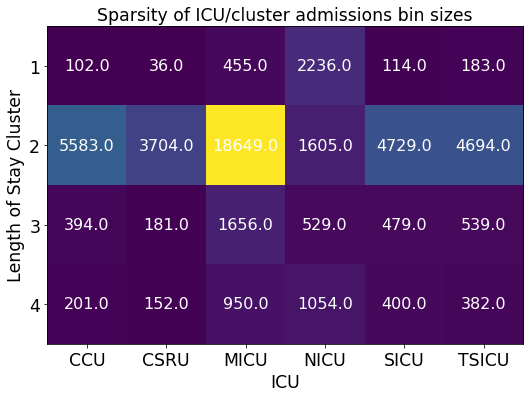

In [35]:
# Prepare dataframe
all_bins = pd.DataFrame(bins)
all_bins.index = unique_predictors[3]
all_bins.columns = [1,2,3,4]

# Name variables for plotting
icus = all_bins.index
diags = all_bins.columns

fig, ax = plt.subplots(figsize=(8,12))
im = ax.imshow(all_bins.transpose())

# We want to show all ticks...
ax.set_xticks(np.arange(len(icus)))
ax.set_yticks(np.arange(len(diags)))
ax.set_xticklabels(icus, size = 'xx-large')
ax.set_yticklabels(diags, size = 'xx-large')
ax.set_xlabel('ICU', size = 'xx-large')
ax.set_ylabel('Length of Stay Cluster', size = 'xx-large')


# Loop over data dimensions and create text annotations.
for i in range(len(diags)):
    for j in range(len(icus)):
        text = ax.text(j, i, all_bins.iloc[j, i],
                       ha="center", va="center", color="w", fontsize = 16)
        

ax.set_title("Sparsity of ICU/cluster admissions bin sizes", size = 'xx-large')
fig.tight_layout(pad = 3)

plt.show()

os.chdir('/Users/chloemaine/Documents/Chloe/BGSE/masters_project/graphs')
fig.savefig('sparsity.png', dpi=100)